In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('./Training_Set.csv')

In [4]:
from rdkit import Chem
from rdkit.Chem import rdmolops

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [5]:
def standardize_smiles_v2(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mol.UpdatePropertyCache(strict=False) # if strict is set to False, the method attempts to update the property cache for all atoms without raising an exception for unusual valences.
        # AssignStereochemistry: Assigns stereochemistry, ensuring that chiral centers are correctly identified and labeled.
        rdmolops.AssignStereochemistry(mol, cleanIt=True, force=True) # AssignStereochemistry: Assigns stereochemistry, ensuring that chiral centers are correctly identified and labeled.
        # Kekulization is the process of assigning single and double bond orders to the aromatic ring systems in a molecule, transforming the aromatic representation to a Kekule representation.
        Chem.SanitizeMol(mol, Chem.SanitizeFlags.SANITIZE_KEKULIZE, catchErrors=True) # catchErrors=True: This parameter means that if an error is encountered during the sanitization process, the function will return an error code rather than raising an exception. This can be useful if you want to handle errors more gracefully, for instance, by logging them and continuing with the next molecule.
        # converting a molecule back to a SMILES string to include information about isomerism
        # non-canonical SMILES string, which might not be unique for the given molecule.
        return Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)
    else:
        return None

In [6]:
df['Standard_SMILES'] = df['SMILES'].apply(standardize_smiles_v2)

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns

/mnt/hyojin0912/anaconda3/envs/umap/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Function to generate ECFP4 1024-bit fingerprint
def generate_fp(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
        return np.array(fp)
    else:
        return None

# Generate fingerprints for all compounds
df['FP'] = df['Standard_SMILES'].apply(generate_fp)

In [9]:
# Filter out molecules where fingerprint generation failed
df = df[df['FP'].notnull()]

In [10]:
# Stack fingerprints into a feature matrix
X = np.stack(df['FP'].values)

In [15]:
# Perform UMAP dimensionality reduction with Jaccard distance
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='jaccard')
embedding = reducer.fit_transform(X)

/mnt/hyojin0912/anaconda3/envs/umap/lib/python3.8/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


In [16]:
# Add UMAP coordinates to DataFrame
df['ECFP4 UMAP1'] = embedding[:, 0]
df['ECFP4 UMAP2'] = embedding[:, 1]

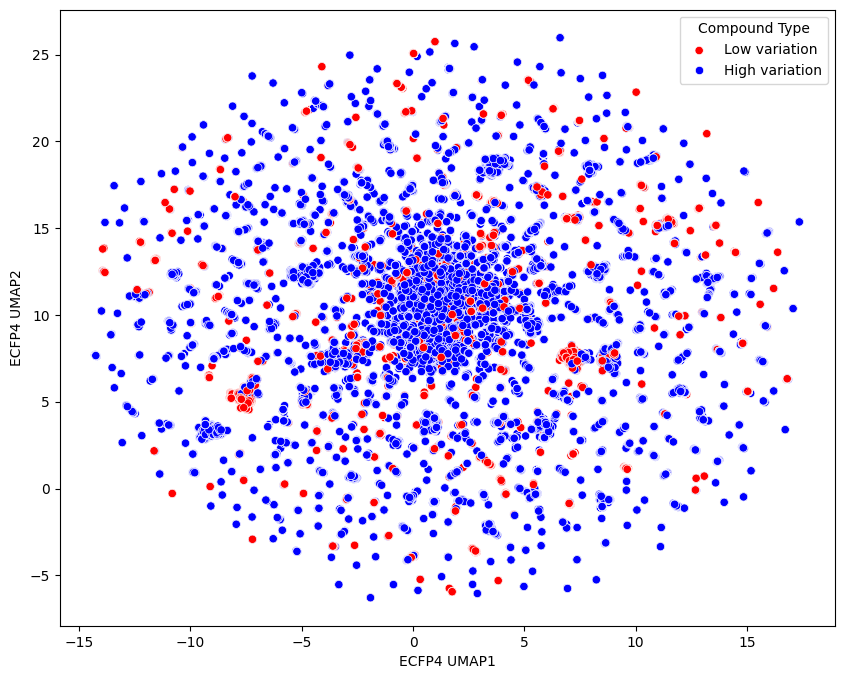

In [18]:
# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='ECFP4 UMAP1', y='ECFP4 UMAP2', hue='CV_group', palette={0: 'blue', 1: 'red'})
#plt.title('UMAP of Compound Structural Variability')
plt.xlabel('ECFP4 UMAP1')
plt.ylabel('ECFP4 UMAP2')
plt.legend(title='Compound Type', labels=['Low variation', 'High variation'])
plt.show()